## Decision Tree

### Preprocessing the Dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sb
from pylab import rcParams

import scipy
from scipy.stats.stats import pearsonr

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 7
plt.style.use('seaborn-whitegrid')

In [3]:
df = pd.read_csv('games.csv')
df = df.drop(columns = ['created_at', 'last_move_at', 'white_id', 'black_id'])

In [4]:
X = df.drop(columns = ['winner'])
y = df.winner

In [5]:
bins = [0, 1200, 1400, 1600, 1800, 2000, 2200, 2300, 2400, 2500, 2700, 3000]

category = ['Novices', 'Class D', 'Class C', 'Class B', 'Class A', 'Expert', 'CM', 'FM', 'IM', 'GM', 'Super GM']

X['white_ratings_interval'] = pd.cut(df['white_rating'], bins, labels = category)
X['black_ratings_interval'] = pd.cut(df['black_rating'], bins, labels = category)

In [6]:
temp = df.copy()
l1 = ['white' if temp ['white_rating'][i]>temp ['black_rating'][i] else 'black' for i in range(temp.shape[0])]
l2 = [abs(temp ['white_rating'][i] - temp['black_rating'][i]) for i in range(temp.shape[0])]
temp['black_ratings_interval'] = X['black_ratings_interval']
temp['white_ratings_interval'] = X['white_ratings_interval']
temp ['higher'] = l1
temp['rating_difference'] = l2
temp = temp[temp['black_ratings_interval']!=temp['white_ratings_interval']]
diff_df = temp[['white_rating', 'black_rating', 'white_ratings_interval','black_ratings_interval', 'rating_difference',  'higher']].copy()



In [7]:
b = [50*i for i in range(21)]
b.append(3000)
c = [str(50*i)+'-'+str(50*(i+1)) for i in range(20)]
c.append('over 1000')
temp['rating_difference_interval'] = pd.cut(temp['rating_difference'], b, labels=c)


diff_df['rating_difference_interval'] = temp['rating_difference_interval'].copy()
diff_df['winner'] = temp['winner'].copy()


In [8]:
diff_df['turns'] = df['turns'].copy()
l1 = [5*i for i in range(44)]
l2 = [str(5*i)+'-'+str(5*(i+1))  for i in range(42)]
l2.append('over 210 moves')


diff_df['moves_interval'] = pd.cut(diff_df['turns'], l1, labels=l2)

In [9]:
final_df = diff_df.copy()
final_df = final_df.drop(columns = ['white_rating', 'black_rating', 'rating_difference', 'turns'])
final_df.head()

,white_ratings_interval,black_ratings_interval,higher,rating_difference_interval,winner,moves_interval
0,Class C,Novices,white,300-350,white,10-15
5,Class D,Novices,white,200-250,draw,0-5
7,Class C,Expert,black,650-700,black,5-10
8,Class C,Class D,white,0-50,black,65-70
11,Class D,Class A,black,450-500,black,35-40


Here We obtained the final dataframe that we will use, to make the computation and the design of the learning algorithm easier. 

### Beginning the Analysis: Decision Tree

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

final_df['white_ratings_interval'] = le.fit_transform(final_df['white_ratings_interval'])
final_df['black_ratings_interval'] = le.fit_transform(final_df['black_ratings_interval'])
final_df['higher'] = le.fit_transform(final_df['higher'])
final_df['rating_difference_interval'] = le.fit_transform(final_df['rating_difference_interval'])
final_df['winner'] = le.fit_transform(final_df['winner'])
final_df['moves_interval'] = le.fit_transform(final_df['moves_interval'].astype('str'))

final_df.head(5)

,white_ratings_interval,black_ratings_interval,higher,rating_difference_interval,winner,moves_interval
0,3,9,1,5,2,1
5,4,9,1,3,1,0
7,3,5,0,13,0,30
8,3,4,1,0,0,34
11,4,1,0,8,0,27


In [11]:
X = final_df.drop(columns = ['winner'])
y = final_df.winner

print('Class lablel: ', np.unique(y))

#class 0 : black
#class 1: draw
#class 2: white

Class lablel:  [0 1 2]


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1, stratify=y)

In [13]:
ify=y)print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [5163  499 5733]
Labels counts in y_train: [3614  349 4013]
Labels counts in y_test: [1549  150 1720]


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions

tree= DecisionTreeClassifier(criterion='entropy', random_state=1)



In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X_t2 = pca.fit_transform(X_train)

tree.fit(X_t2, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

We used PCA to reduce the dimensionality of the dataset from 5 into 2 so that we are able to draw the decision region plot.

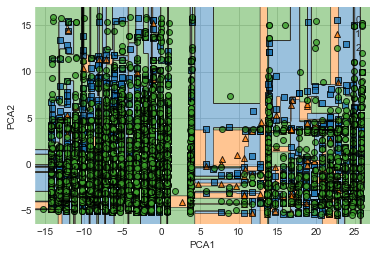

In [16]:
plot_decision_regions(X_t2, y_train.to_numpy(), tree)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='upper right')

plt.show()

In [25]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

clf = DecisionTreeClassifier(criterion='entropy', random_state=1)
model = clf.fit(X_train, y_train)

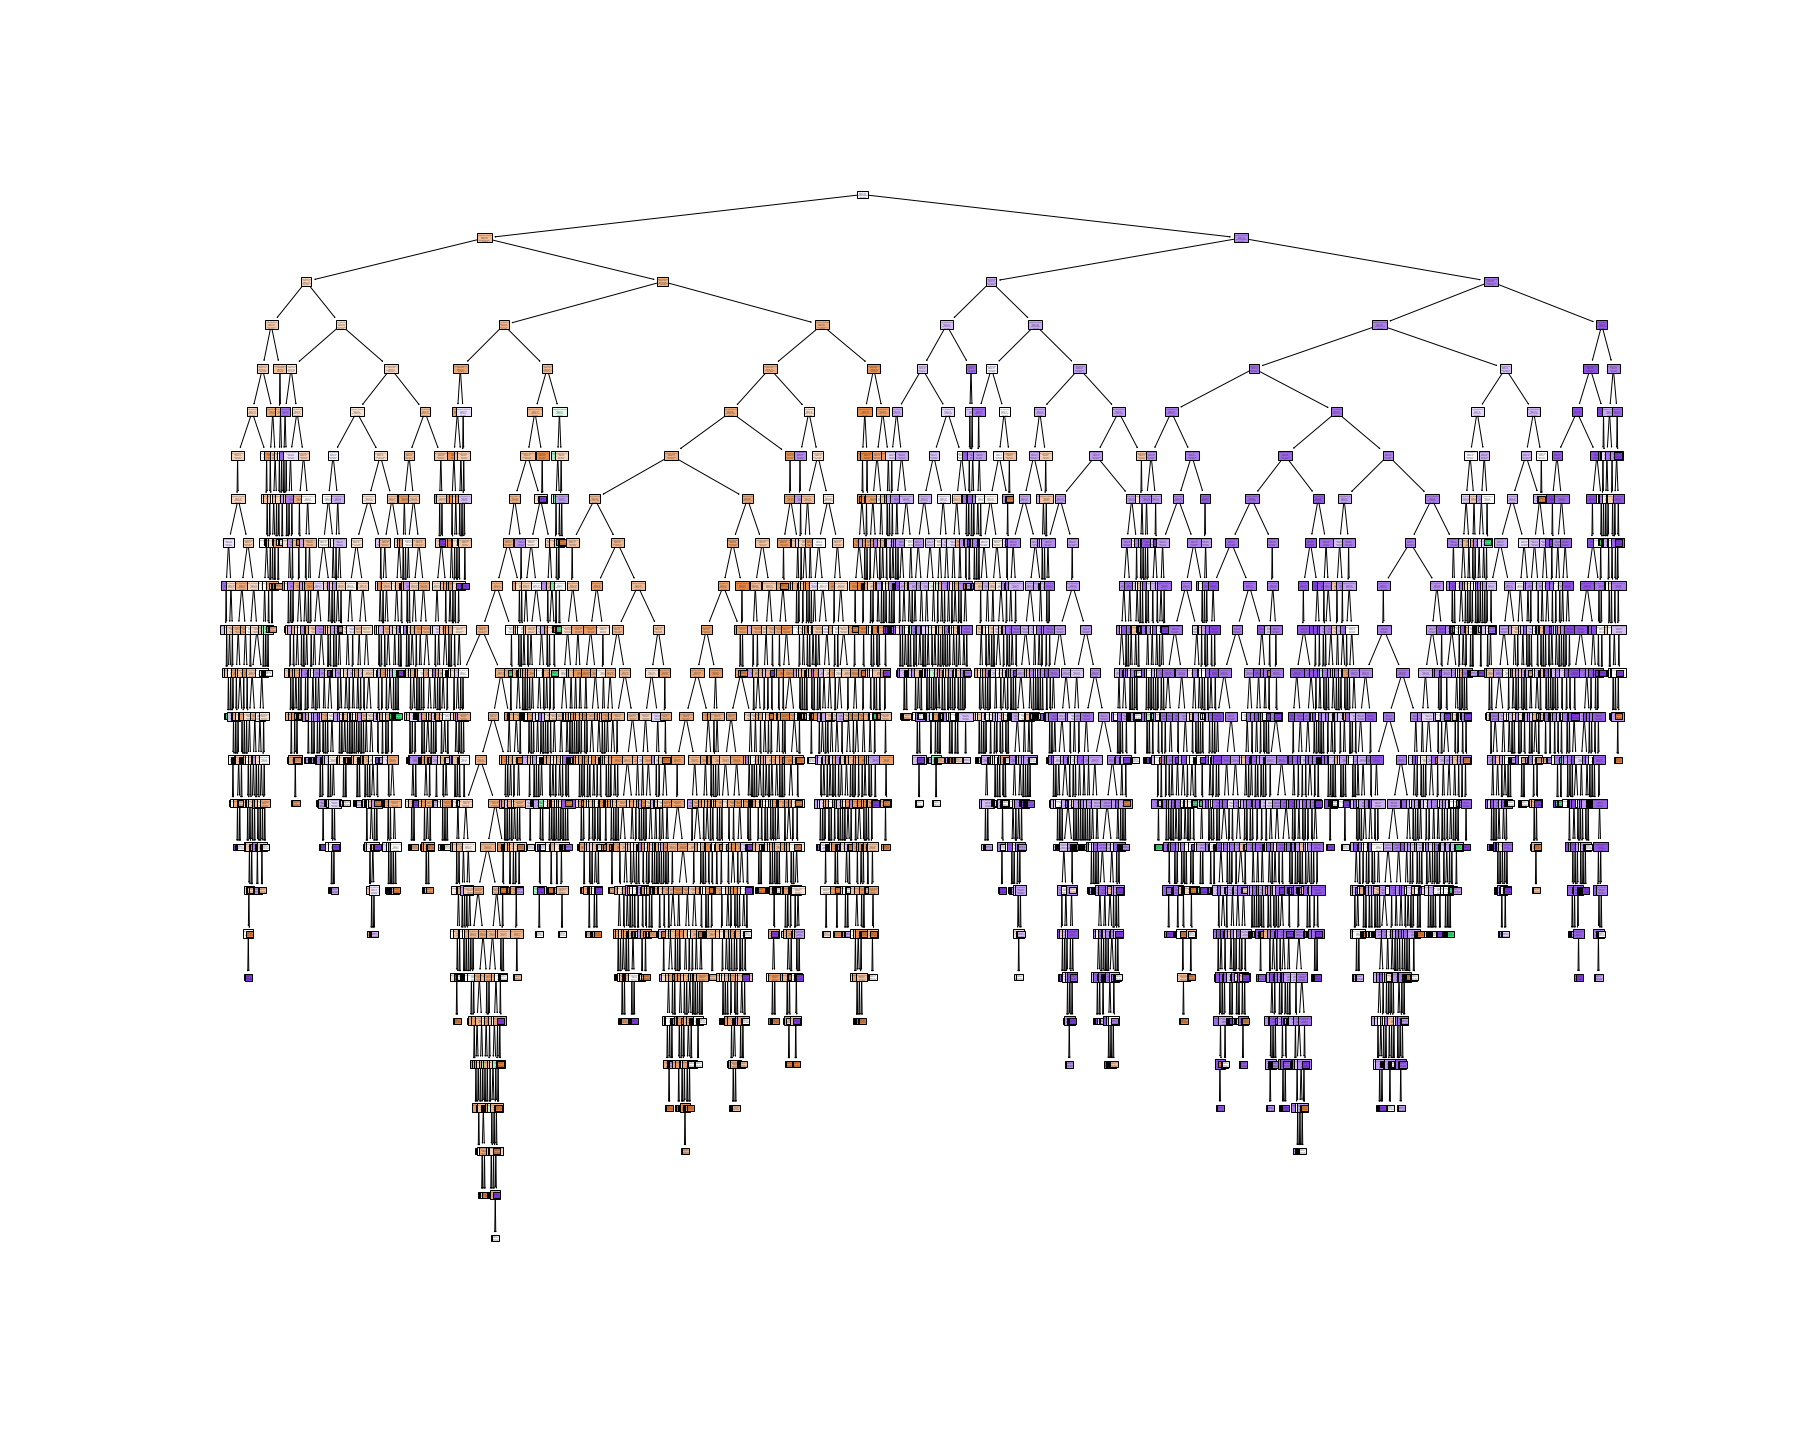

In [1]:
from IPython.display import Image

Image('decistion_tree.png')

As it is very difficult to read the picture above, we will provide a text representation of the same tree

In [27]:
txt_rep = tree.export_text(clf)
print(txt_rep)
with open("decision_tree.txt", "w") as fout:
    fout.write(txt_rep)

|--- feature_2 <= 0.50
|   |--- feature_3 <= 2.50
|   |   |--- feature_4 <= 14.50
|   |   |   |--- feature_0 <= 7.00
|   |   |   |   |--- feature_4 <= 11.50
|   |   |   |   |   |--- feature_4 <= 8.50
|   |   |   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_0 >  0.50
|   |   |   |   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_4 <= 2.50
|   |   |   |   |   |   |   |   |   |--- feature_4 <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- feature_4 >  1.50
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= 3.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  3.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- feature_4 >  2.50
|   |   |   |   |   |   |   |   |   |--- feature_4 <= 4.50
|   |   |   |   |   |   |   | 

we see that the 'Higher' attribute is the first division node which splits the tree in two. which makes sense since the player with the higher rating would likely be the one to win the match.

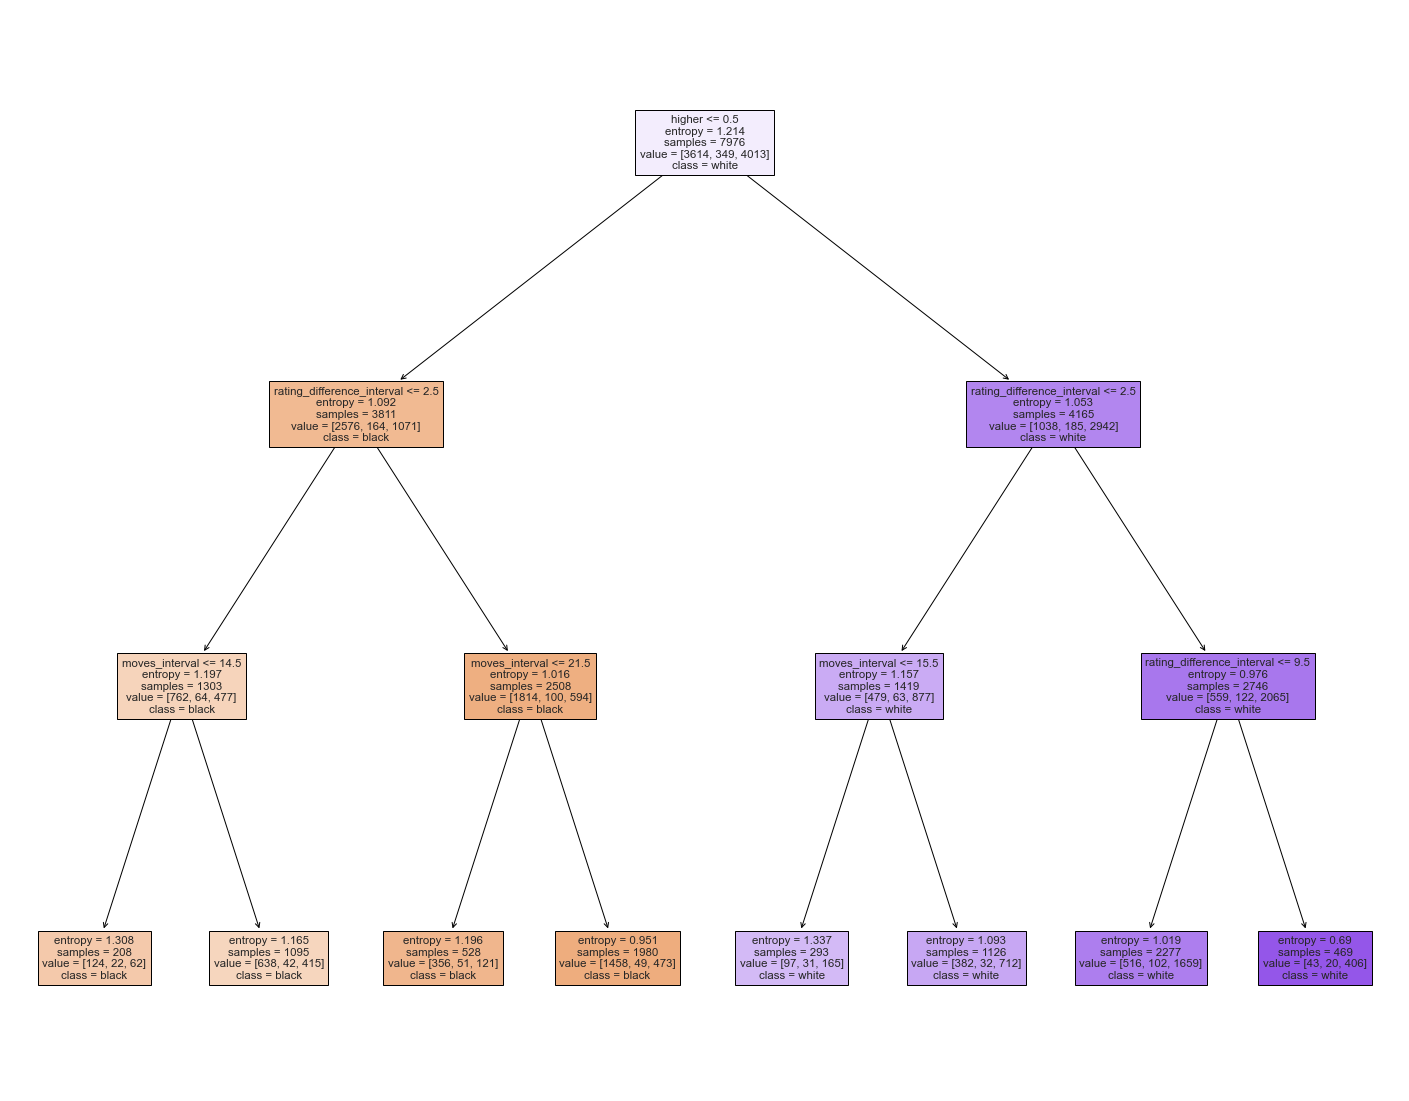

In [28]:
clf2 = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=1)
clf2.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf2, 
                   feature_names=X.columns,  
                   class_names=['black', 'draw', 'white'],
                   filled=True)

The figure above represent the tree up to the depth 3. We see that at level 0 (or on Node 0) the winner is projected to be white. This could be because the player with the white piece laways makes the first move. On the level 1 the superiority of the rating predicts the the winner. 

In [29]:
clf.score(X,y)

0.748398420359807

looking at the model score, we could conclude that the model is good as an accuracy of 0.75 is considered good.